In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Any, Tuple, Optional
from tqdm.auto import tqdm

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [3]:
def load_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
    model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
                                                 torch_dtype=torch.bfloat16)
    model.eval()
    model.to(device)
    return tokenizer, model

tokenizer, model = load_model()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
device = get_device()
print(device)

cpu


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Any, Tuple, Optional
from tqdm.auto import tqdm


def get_device():
    """Get the appropriate device for computation, avoiding MPS."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def prepare_prompt(prompt: str, tokenizer) -> str:
    """Format the prompt using the chat template if available"""
    if hasattr(tokenizer, 'apply_chat_template'):
        messages = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        return formatted_prompt
    return prompt


def tokenize_prompts(clean_prompt: str, corrupted_prompt: str, tokenizer, device=None):
    """Tokenize prompts and prepare model inputs"""
    # Get appropriate device
    if device is None:
        device = get_device()
        
    # Format prompts
    formatted_clean = prepare_prompt(clean_prompt, tokenizer)
    formatted_corrupted = prepare_prompt(corrupted_prompt, tokenizer)
    
    # Tokenize
    clean_tokens = tokenizer(formatted_clean, return_tensors="pt")
    corrupted_tokens = tokenizer(formatted_corrupted, return_tensors="pt")
    
    # Move to device
    clean_tokens = {k: v.to(device) for k, v in clean_tokens.items()}
    corrupted_tokens = {k: v.to(device) for k, v in corrupted_tokens.items()}
    
    print(f"Clean prompt: {formatted_clean}")
    print(f"Corrupted prompt: {formatted_corrupted}")
    
    return clean_tokens, corrupted_tokens, formatted_clean, formatted_corrupted


def extract_hidden_states(model, inputs, num_layers=None):
    """Extract hidden states from all layers for given inputs"""
    # Determine number of layers if not provided
    if num_layers is None:
        num_layers = len(model.model.layers)
    
    # Get device
    device = next(model.parameters()).device
    
    # Initialize dictionary to store hidden states
    hidden_states = {f"layer_{i}": [] for i in range(num_layers)}
    
    # Define hook function to capture hidden states
    def create_hook(layer_idx):
        def hook_fn(module, inputs, outputs):
            # Get the input hidden states (residual stream)
            if isinstance(inputs, tuple):
                states = inputs[0].detach().clone()
            else:
                states = inputs.detach().clone()
            hidden_states[f"layer_{layer_idx}"].append(states)
            
        return hook_fn
    
    # Register hooks for all layers
    hooks = []
    for idx, layer in enumerate(model.model.layers):
        if idx < num_layers:
            hook = layer.register_forward_hook(create_hook(idx))
            hooks.append(hook)
    
    # Process input through the model
    with torch.no_grad():
        try:
            model(**inputs)
        except RuntimeError as e:
            if "MPS" in str(e):
                print("Error detected. Moving to CPU...")
                cpu_device = torch.device('cpu')
                model = model.to(cpu_device)
                inputs = {k: v.to(cpu_device) for k, v in inputs.items()}
                model(**inputs)
            else:
                # Re-raise other errors
                raise
    
    # Remove all hooks
    for hook in hooks:
        hook.remove()
    
    return hidden_states

def patch_and_get_next_token(model, input_ids, attention_mask, layer_idx, corrupted_hidden_states):
    """
    Run a forward pass with patching at the specified layer
    and return the predicted next token
    """
    # Flag to track patching
    patched = [False]
    
    # Define patching hook for forward_pre_hook (gets only module and input)
    def patching_hook(module, inputs):
        if not patched[0]:
            # Get current hidden states
            if isinstance(inputs, tuple):
                hidden_states = inputs[0]
            else:
                hidden_states = inputs
            
            # Get corrupted hidden states for this layer
            layer_key = f"layer_{layer_idx}"
            corrupted_states = corrupted_hidden_states[layer_key]
            
            # Check if we have corrupted states for this position
            if len(corrupted_states) > 0:
                # Use the last available corrupted state
                corrupted_state = corrupted_states[-1]
                
                # Create patched hidden states
                patched_states = hidden_states.clone()
                
                # Determine how much we can patch
                min_seq_len = min(corrupted_state.shape[1], patched_states.shape[1])
                
                # Patch what we can
                patched_states[:, :min_seq_len, :] = corrupted_state[:, :min_seq_len, :]
                
                # Mark as patched
                patched[0] = True
                
                # Return patched hidden states
                if isinstance(inputs, tuple):
                    return (patched_states,) + inputs[1:]
                else:
                    return patched_states
        
        return inputs
    
    # Register the hook - using forward_pre_hook
    hook = model.model.layers[layer_idx].register_forward_pre_hook(patching_hook)
    
    try:
        # Run model with patching
        with torch.no_grad():
            try:
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            except RuntimeError as e:
                # If any error occurs, try CPU
                print(f"Error during patching: {str(e)}. Trying CPU...")
                # Save original device to move back later
                original_device = next(model.parameters()).device
                # Move everything to CPU
                model = model.to('cpu')
                input_ids = input_ids.to('cpu')
                attention_mask = attention_mask.to('cpu')
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                # Move model back
                model.to(original_device)
            
        # Get the next token prediction
        next_token_logits = outputs.logits[0, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).item()
        
        return next_token
    finally:
        # Always remove the hook
        hook.remove()





def run_initial_passes(model, clean_tokens, corrupted_tokens, num_layers=None):
    """
    Run initial forward passes and extract hidden states for both prompts
    
    Returns:
        Tuple of (clean_hidden_states, corrupted_hidden_states)
    """
    print("Running initial forward passes...")
    
    # Extract hidden states for clean prompt
    clean_hidden_states = extract_hidden_states(
        model, clean_tokens, num_layers=num_layers
    )
    
    # Extract hidden states for corrupted prompt
    corrupted_hidden_states = extract_hidden_states(
        model, corrupted_tokens, num_layers=num_layers
    )
    
    print("Initial passes complete.")
    return clean_hidden_states, corrupted_hidden_states


def generate_text(model, tokenizer, tokens, max_new_tokens=100):
    """Generate text from input tokens"""
    # Convert tokens to dict if it's not already (for compatibility)
    if not isinstance(tokens, dict):
        tokens = {'input_ids': tokens.input_ids, 'attention_mask': tokens.attention_mask}
    
    # Get device from tokens
    device = tokens['input_ids'].device
    
    with torch.no_grad():
        try:
            output_ids = model.generate(
                input_ids=tokens['input_ids'],
                attention_mask=tokens['attention_mask'],
                max_new_tokens=max_new_tokens,
                pad_token_id=tokenizer.eos_token_id
            )
        except RuntimeError as e:
            if "MPS" in str(e) or "CUDA" in str(e):
                print("Device error detected. Falling back to CPU...")
                # Move model to CPU temporarily
                original_device = next(model.parameters()).device
                model.to('cpu')
                # Move inputs to CPU
                cpu_tokens = {k: v.to('cpu') for k, v in tokens.items()}
                
                # Try generation on CPU
                output_ids = model.generate(
                    input_ids=cpu_tokens['input_ids'],
                    attention_mask=cpu_tokens['attention_mask'],
                    max_new_tokens=max_new_tokens,
                    pad_token_id=tokenizer.eos_token_id
                )
                
                # Move model back
                model.to(original_device)
            else:
                # Re-raise other errors
                raise
    
    # Get the full output text
    full_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # Get just the generated text (excluding the input)
    input_length = tokens['input_ids'].shape[1]
    gen_ids = output_ids[0, input_length:]
    generated_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    # Return all information
    return {
        "full_output": full_output,
        "generated_text": generated_text,
        "input_ids": tokens['input_ids'][0].tolist(),
        "generated_ids": gen_ids.tolist(),
        "all_tokens": output_ids[0].tolist()
    }


def generate_baseline_outputs(model, tokenizer, clean_tokens, corrupted_tokens, max_new_tokens=100):
    """Generate baseline outputs for both clean and corrupted prompts"""
    print("Generating baseline outputs...")
    
    # Generate from clean prompt
    clean_generation = generate_text(model, tokenizer, clean_tokens, max_new_tokens)
    print(f"Clean output: {clean_generation['generated_text']}")
    
    # Generate from corrupted prompt
    corrupted_generation = generate_text(model, tokenizer, corrupted_tokens, max_new_tokens)
    print(f"Corrupted output: {corrupted_generation['generated_text']}")
    
    return clean_generation, corrupted_generation



def run_generation_phase_patching(
    model, 
    tokenizer, 
    clean_tokens, 
    corrupted_hidden_states, 
    layers_to_patch=None, 
    max_tokens_to_generate=20,
    device=None
):
    """
    Run generation-phase patching as described in the methodology.
    
    For each token position in the generation:
    1. Generate the token normally for the clean prompt
    2. For each layer, patch the hidden states from the corrupted run
    3. See if this changes the output token
    4. Continue generation with the normal token (not the patched one)
    5. Repeat for each token position
    """
    print("Running generation-phase patching...")
    
    # Get appropriate device
    if device is None:
        device = get_device()
    
    # Determine which layers to patch
    if layers_to_patch is None:
        layers_to_patch = list(range(len(model.model.layers)))
    
    # Start with the clean prompt tokens
    current_input_ids = clean_tokens['input_ids'].clone()
    
    # Track the clean generation sequence
    clean_generation_ids = []
    
    # Track patching results for each token position
    token_patching_results = []
    
    # Generate tokens one by one
    for token_idx in tqdm(range(max_tokens_to_generate)):
        # Current input length
        curr_length = current_input_ids.shape[1]
        
        # Create attention mask
        attention_mask = torch.ones((1, curr_length), device=device)
        
        # Get the next token from clean generation (without patching)
        with torch.no_grad():
            clean_outputs = model(
                input_ids=current_input_ids,
                attention_mask=attention_mask
            )
            clean_next_token_logits = clean_outputs.logits[0, -1, :]
            clean_next_token = torch.argmax(clean_next_token_logits, dim=-1).item()
            
        # Add this token to our clean generation tracking
        clean_generation_ids.append(clean_next_token)
        
        # For each layer, run patching and check effect
        layer_results = {}
        
        for layer_idx in layers_to_patch:
            # Skip patching if we don't have corrupted hidden states for this layer
            layer_key = f"layer_{layer_idx}"
            if layer_key not in corrupted_hidden_states:
                continue
                
            # Try patching at this layer
            patched_token = patch_and_get_next_token(
                model,
                current_input_ids, 
                attention_mask,
                layer_idx,
                corrupted_hidden_states
            )
            
            # Record results
            layer_results[layer_idx] = {
                "clean_token": clean_next_token,
                "clean_token_str": tokenizer.decode(clean_next_token),
                "patched_token": patched_token,
                "patched_token_str": tokenizer.decode(patched_token),
                "changed": patched_token != clean_next_token
            }
        
        # Add results for this token position
        token_patching_results.append({
            "token_position": token_idx,
            "context": tokenizer.decode(current_input_ids[0]),
            "clean_next_token": clean_next_token,
            "clean_next_token_str": tokenizer.decode(clean_next_token),
            "layer_results": layer_results
        })
        
        # Continue generation with the clean token (important: we're not using patched tokens)
        current_input_ids = torch.cat([
            current_input_ids, 
            torch.tensor([[clean_next_token]], device=device)
        ], dim=1)
        
        # Check if we've reached the end token
        if clean_next_token == tokenizer.eos_token_id:
            break
    
    # Save final clean generation
    clean_gen_text = tokenizer.decode(
        current_input_ids[0, clean_tokens['input_ids'].shape[1]:], 
        skip_special_tokens=True
    )
    
    # Return patching results
    patching_results = {
        "token_results": token_patching_results,
        "clean_generation_ids": clean_generation_ids,
        "clean_generation_text": clean_gen_text,
        "layers_patched": layers_to_patch
    }
    
    print("Generation-phase patching complete.")
    return patching_results


def analyze_patching_results(patching_results, tokenizer):
    """Analyze patching results to identify important layers for reasoning"""
    if not patching_results:
        print("No patching results found.")
        return None
    
    # Track which layers change tokens at which positions
    token_changes = {layer: [] for layer in patching_results["layers_patched"]}
    
    # Analyze each token position
    for token_result in patching_results["token_results"]:
        position = token_result["token_position"]
        
        for layer_idx, layer_result in token_result["layer_results"].items():
            if layer_result["changed"]:
                # Record that this layer changed this token
                token_changes[layer_idx].append({
                    "position": position,
                    "clean_token": layer_result["clean_token_str"],
                    "patched_token": layer_result["patched_token_str"],
                    "context": token_result["context"]
                })
    
    # Find layers with the most impact
    layer_impact = {layer: len(changes) for layer, changes in token_changes.items()}
    most_impactful_layers = sorted(
        layer_impact.items(), 
        key=lambda x: x[1], 
        reverse=True
    )
    
    # Find token positions with the most changes
    position_changes = {}
    for token_result in patching_results["token_results"]:
        position = token_result["token_position"]
        changes = sum(1 for layer_result in token_result["layer_results"].values() if layer_result["changed"])
        position_changes[position] = changes
    
    most_affected_positions = sorted(
        position_changes.items(),
        key=lambda x: x[1],
        reverse=True
    )
    
    # Compile analysis
    analysis = {
        "token_changes": token_changes,
        "layer_impact": layer_impact,
        "most_impactful_layers": most_impactful_layers,
        "position_changes": position_changes,
        "most_affected_positions": most_affected_positions,
    }
    
    return analysis


def visualize_layer_impact(analysis_results, save_path=None):
    """Visualize the impact of each layer on token generation"""
    if not analysis_results:
        print("No analysis results found.")
        return
        
    # Extract data for plotting
    layers = list(analysis_results["layer_impact"].keys())
    impact_values = list(analysis_results["layer_impact"].values())
    
    # Create plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(layers, impact_values, color='skyblue')
    
    # Add value annotations
    for bar, value in zip(bars, impact_values):
        if value > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.1,
                str(value),
                ha='center',
                fontweight='bold'
            )
    
    plt.title('Impact of Layer Patching on Token Generation', fontsize=15)
    plt.xlabel('Model Layer', fontsize=12)
    plt.ylabel('Number of Tokens Changed', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    
    # Highlight most impactful layers
    if impact_values and max(impact_values) > 0:
        most_impactful = analysis_results["most_impactful_layers"][0][0]
        bars[layers.index(most_impactful)].set_color('crimson')
        
        # Add text annotation for most impactful
        plt.annotate(
            f'Most impactful: Layer {most_impactful}',
            xy=(most_impactful, impact_values[layers.index(most_impactful)]),
            xytext=(most_impactful, max(impact_values) * 1.1),
            arrowprops=dict(arrowstyle='->'),
            ha='center',
            fontweight='bold'
        )
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


def visualize_token_position_impact(patching_results, analysis_results, tokenizer, save_path=None):
    """Visualize which token positions are most affected by patching"""
    if not analysis_results:
        print("No analysis results found.")
        return
        
    # Extract data for plotting
    positions = list(analysis_results["position_changes"].keys())
    impact_values = list(analysis_results["position_changes"].values())
    
    # Get token strings
    token_strings = []
    for pos in positions:
        if pos < len(patching_results["token_results"]):
            token = patching_results["token_results"][pos]["clean_next_token_str"]
            token_strings.append(f"{pos}: '{token}'")
        else:
            token_strings.append(str(pos))
    
    # Create plot
    plt.figure(figsize=(14, 6))
    bars = plt.bar(token_strings, impact_values, color='lightgreen')
    
    # Add value annotations
    for bar, value in zip(bars, impact_values):
        if value > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.1,
                str(value),
                ha='center',
                fontweight='bold'
            )
    
    plt.title('Token Positions Most Affected by Layer Patching', fontsize=15)
    plt.xlabel('Token Position and Value', fontsize=12)
    plt.ylabel('Number of Layers Causing Change', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    
    # Highlight most affected position
    if impact_values and max(impact_values) > 0:
        most_affected_idx = impact_values.index(max(impact_values))
        bars[most_affected_idx].set_color('purple')
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


def visualize_heatmap(patching_results, save_path=None):
    """Create a heatmap showing which layers affect which token positions"""
    if not patching_results:
        print("No patching results found.")
        return
    
    # Get token results
    token_results = patching_results["token_results"]
    
    # Create layers x tokens matrix
    layers = sorted(patching_results["layers_patched"])
    tokens = list(range(len(token_results)))
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(layers), len(tokens)))
    
    # Fill the heatmap data
    for t_idx, token_result in enumerate(token_results):
        for l_idx, layer in enumerate(layers):
            if layer in token_result["layer_results"]:
                if token_result["layer_results"][layer]["changed"]:
                    heatmap_data[l_idx, t_idx] = 1
    
    # Create token labels
    token_labels = []
    for t_idx, token_result in enumerate(token_results):
        token_str = token_result["clean_next_token_str"]
        # Truncate long tokens
        if len(token_str) > 10:
            token_str = token_str[:8] + "..."
        token_labels.append(f"{t_idx}: '{token_str}'")
    
    # Create heatmap
    plt.figure(figsize=(14, 8))
    plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    
    # Add labels
    plt.yticks(range(len(layers)), [f"Layer {l}" for l in layers])
    plt.xticks(range(len(tokens)), token_labels, rotation=45, ha='right')
    
    plt.colorbar(ticks=[0, 1], label='Token Changed')
    plt.title('Heatmap of Layer Impact on Token Generation', fontsize=15)
    plt.xlabel('Token Position and Value', fontsize=12)
    plt.ylabel('Model Layer', fontsize=12)
    
    # Add grid
    plt.grid(visible=False)
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


def generate_detailed_report(patching_results, analysis_results, clean_prompt, corrupted_prompt, corrupted_generation=None):
    """Generate a detailed text report of the patching results"""
    if not patching_results or not analysis_results:
        print("Missing patching or analysis results.")
        return ""
    
    # Start building the report
    report = []
    report.append("=" * 80)
    report.append("GENERATION-PHASE ACTIVATION PATCHING REPORT")
    report.append("=" * 80)
    
    # Baseline outputs
    report.append("\nBASELINE OUTPUTS:")
    report.append(f"Clean prompt: {clean_prompt}")
    report.append(f"Clean generation: {patching_results['clean_generation_text']}")
    report.append(f"Corrupted prompt: {corrupted_prompt}")
    if corrupted_generation:
        report.append(f"Corrupted generation: {corrupted_generation['generated_text']}")
    
    # Most impactful layers
    report.append("\nMOST IMPACTFUL LAYERS:")
    for layer, impact in analysis_results["most_impactful_layers"][:5]:
        if impact > 0:
            report.append(f"Layer {layer}: Changed {impact} tokens")
    
    # Most affected token positions
    report.append("\nMOST AFFECTED TOKEN POSITIONS:")
    for pos, changes in analysis_results["most_affected_positions"][:5]:
        if changes > 0:
            token = patching_results["token_results"][pos]["clean_next_token_str"]
            report.append(f"Position {pos} ('{token}'): Changed by {changes} layers")
    
    # Detailed token-by-token analysis
    report.append("\nDETAILED TOKEN-BY-TOKEN ANALYSIS:")
    for token_result in patching_results["token_results"]:
        pos = token_result["token_position"]
        clean_token = token_result["clean_next_token_str"]
        
        # Only show interesting positions (where something changed)
        changes = [layer for layer, result in token_result["layer_results"].items() 
                  if result["changed"]]
        
        if changes:
            report.append(f"\nToken position {pos} (Clean: '{clean_token}'):")
            context = token_result["context"]
            report.append(f"Context: {context}")
            
            for layer in sorted(changes):
                result = token_result["layer_results"][layer]
                report.append(f"  Layer {layer}: '{result['clean_token_str']}' → '{result['patched_token_str']}'")
    
    return "\n".join(report)


def generate_concise_insights(patching_results, analysis_results, corrupted_generation=None):
    """Generate concise insights about the most important findings"""
    if not patching_results or not analysis_results:
        print("Missing patching or analysis results.")
        return ""
    
    # Start building insights
    insights = []
    insights.append("KEY INSIGHTS FROM ACTIVATION PATCHING:")
    
    # Check if we had any impact
    total_changes = sum(analysis_results["layer_impact"].values())
    if total_changes == 0:
        insights.append("No token changes observed during patching. The model's reasoning path appears robust to patching in these layers.")
        return "\n".join(insights)
    
    # Find critical layers
    critical_layers = [layer for layer, impact in analysis_results["most_impactful_layers"] if impact > 0][:3]
    if critical_layers:
        layers_str = ", ".join([f"Layer {l}" for l in critical_layers])
        insights.append(f"Critical layers for reasoning: {layers_str}")
    
    # Find critical reasoning steps
    critical_positions = [pos for pos, changes in analysis_results["most_affected_positions"] if changes > 0][:3]
    if critical_positions:
        tokens = []
        for pos in critical_positions:
            if pos < len(patching_results["token_results"]):
                token = patching_results["token_results"][pos]["clean_next_token_str"]
                tokens.append(f"'{token}' (pos {pos})")
        
        tokens_str = ", ".join(tokens)
        insights.append(f"Critical reasoning tokens: {tokens_str}")
    
    # Check if any early tokens were affected
    early_affected = [pos for pos in critical_positions if pos < 3]
    if early_affected:
        insights.append("Early tokens in the generation were affected, suggesting the model's reasoning path diverges early.")
    
    # Check if patching created token sequences similar to corrupted output
    if corrupted_generation:
        corrupt_text = corrupted_generation["generated_text"]
        patched_sequences = []
        
        for token_result in patching_results["token_results"]:
            for layer, result in token_result["layer_results"].items():
                if result["changed"] and result["patched_token_str"] in corrupt_text:
                    patched_sequences.append(f"Layer {layer} at position {token_result['token_position']}")
                    break
        
        if patched_sequences:
            insights.append(f"Patching produced tokens matching the corrupted output at: {', '.join(patched_sequences[:3])}")
    
    return "\n".join(insights)


def run_generation_phase_patching_analysis(
    model,
    tokenizer,
    clean_prompt,
    corrupted_prompt,
    layers_to_patch=None,
    max_tokens_to_generate=20,
    max_new_tokens=100,
    device=None,
    save_visualizations=False,
    visualization_prefix="patching_"
):
    """
    Run a complete generation-phase patching analysis.
    
    This function combines all the above functions into a single workflow.
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        clean_prompt: The base prompt without additional information
        corrupted_prompt: The prompt with additional information (e.g., a hint)
        layers_to_patch: List of layer indices to patch (default: all layers)
        max_tokens_to_generate: Maximum number of tokens to analyze with patching
        max_new_tokens: Maximum tokens to generate for baseline outputs
        device: Device to run on (if None, will use get_device())
        save_visualizations: Whether to save visualization files
        visualization_prefix: Prefix for saved visualization files
    
    Returns:
        Dictionary with all results
    """
    # Get appropriate device
    if device is None:
        device = get_device()
    
    print(f"Using device: {device}")
    
    # 1. Tokenize prompts
    clean_tokens, corrupted_tokens, formatted_clean, formatted_corrupted = tokenize_prompts(
        clean_prompt, corrupted_prompt, tokenizer, device
    )
    
    # 2. Generate baseline outputs
    clean_generation, corrupted_generation = generate_baseline_outputs(
        model, tokenizer, clean_tokens, corrupted_tokens, max_new_tokens
    )
    
    # 3. Run initial passes to extract hidden states
    clean_hidden_states, corrupted_hidden_states = run_initial_passes(
        model, clean_tokens, corrupted_tokens
    )
    
    # 4. Run generation-phase patching
    patching_results = run_generation_phase_patching(
        model, 
        tokenizer, 
        clean_tokens, 
        corrupted_hidden_states, 
        layers_to_patch=layers_to_patch,
        max_tokens_to_generate=max_tokens_to_generate,
        device=device
    )
    
    # 5. Analyze results
    analysis_results = analyze_patching_results(patching_results, tokenizer)
    
    # 6. Visualize results
    if save_visualizations:
        visualize_layer_impact(
            analysis_results, 
            save_path=f"{visualization_prefix}layer_impact.png"
        )
        visualize_token_position_impact(
            patching_results,
            analysis_results, 
            tokenizer,
            save_path=f"{visualization_prefix}token_impact.png"
        )
        visualize_heatmap(
            patching_results, 
            save_path=f"{visualization_prefix}heatmap.png"
        )
    else:
        visualize_layer_impact(analysis_results)
        visualize_token_position_impact(patching_results, analysis_results, tokenizer)
        visualize_heatmap(patching_results)
    
    # 7. Generate reports
    detailed_report = generate_detailed_report(
        patching_results, 
        analysis_results, 
        formatted_clean, 
        formatted_corrupted, 
        corrupted_generation
    )
    concise_insights = generate_concise_insights(
        patching_results,
        analysis_results,
        corrupted_generation
    )
    
    print("\n" + detailed_report)
    print("\n" + concise_insights)
    
    # Return all results
    return {
        "clean_prompt": formatted_clean,
        "corrupted_prompt": formatted_corrupted,
        "clean_generation": clean_generation,
        "corrupted_generation": corrupted_generation,
        "patching_results": patching_results,
        "analysis_results": analysis_results,
        "detailed_report": detailed_report,
        "concise_insights": concise_insights
    }


Loading model to device: cpu
Using device: cpu
Clean prompt: <｜begin▁of▁sentence｜><｜User｜>Solve this quadratic equation: 3x^2 - 12x + 9 = 0<｜Assistant｜><think>

Corrupted prompt: <｜begin▁of▁sentence｜><｜User｜>Solve this equation: 3x^2 - 12x + 9 = 0

Hint: Quadratic Formula<｜Assistant｜><think>

Generating baseline outputs...
Clean output: To solve the quadratic equation \(3x^2 - 12x + 9 = 0\), I will start by simplifying it. I can divide every term by 3 to make the coefficients smaller and easier to work with, resulting in the equation \(x^2 - 4x + 3 = 0\).

Next, I will identify the coefficients of the quadratic equation in the standard form \(ax^2 + bx + c = 0\), where \(a
Corrupted output: To solve the quadratic equation \( 3x^2 - 12x + 9 = 0 \), I'll start by identifying the coefficients. Here, \( a = 3 \), \( b = -12 \), and \( c = 9 \).

Next, I'll calculate the discriminant using the formula \( \Delta = b^2 - 4ac \). Plugging in the values, I get \( \Delta = (-12)^2 - 4 \times
Run

  0%|          | 0/10 [00:00<?, ?it/s]

Generation-phase patching complete.


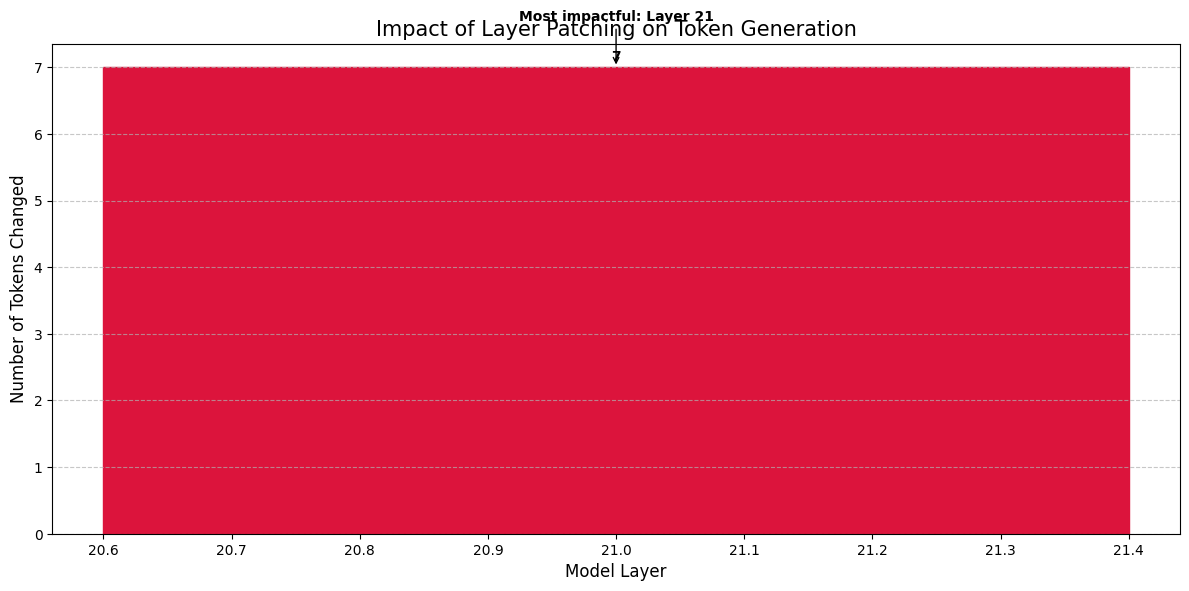

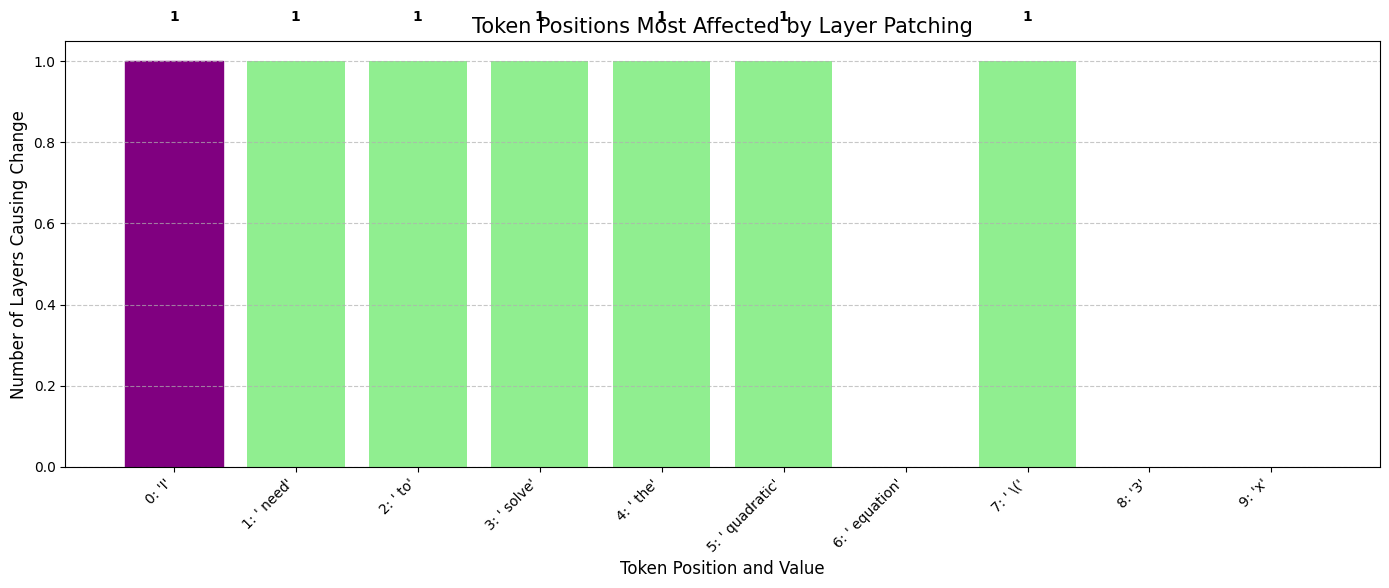

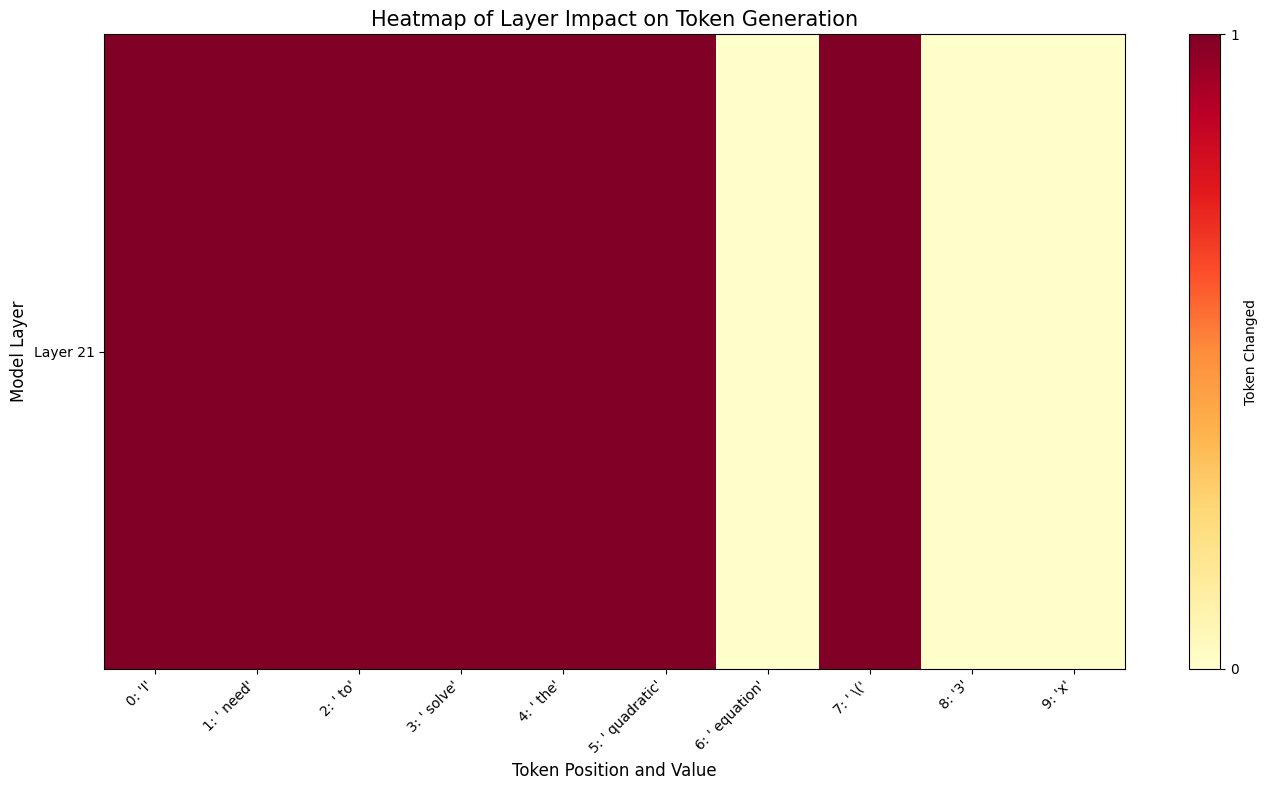


GENERATION-PHASE ACTIVATION PATCHING REPORT

BASELINE OUTPUTS:
Clean prompt: <｜begin▁of▁sentence｜><｜User｜>Solve this quadratic equation: 3x^2 - 12x + 9 = 0<｜Assistant｜><think>

Clean generation: I need to solve the quadratic equation \(3x
Corrupted prompt: <｜begin▁of▁sentence｜><｜User｜>Solve this equation: 3x^2 - 12x + 9 = 0

Hint: Quadratic Formula<｜Assistant｜><think>

Corrupted generation: To solve the quadratic equation \( 3x^2 - 12x + 9 = 0 \), I'll start by identifying the coefficients. Here, \( a = 3 \), \( b = -12 \), and \( c = 9 \).

Next, I'll calculate the discriminant using the formula \( \Delta = b^2 - 4ac \). Plugging in the values, I get \( \Delta = (-12)^2 - 4 \times

MOST IMPACTFUL LAYERS:
Layer 21: Changed 7 tokens

MOST AFFECTED TOKEN POSITIONS:
Position 0 ('I'): Changed by 1 layers
Position 1 (' need'): Changed by 1 layers
Position 2 (' to'): Changed by 1 layers
Position 3 (' solve'): Changed by 1 layers
Position 4 (' the'): Changed by 1 layers

DETAILED TOKEN-BY-TO

In [9]:

def example_patching_analysis(model, tokenizer):
    """Example demonstrating how to use the generation-phase patching framework"""
    
    # Get appropriate device
    device = get_device()
    print(f"Loading model to device: {device}")
    
    # Load model with appropriate dtype for the device
    model = model
    tokenizer = tokenizer
    
    # If using CPU, ensure model is on CPU
    if device.type == 'cpu':
        model = model.to('cpu')
    
    # Define clean and corrupted prompts
    clean_prompt = "Solve this quadratic equation: 3x^2 - 12x + 9 = 0"
    corrupted_prompt = "Solve this equation: 3x^2 - 12x + 9 = 0\n\nHint: Quadratic Formula"
    
    # Run the full analysis
    results = run_generation_phase_patching_analysis(
        model=model,
        tokenizer=tokenizer,
        clean_prompt=clean_prompt,
        corrupted_prompt=corrupted_prompt,
        layers_to_patch=[21],  # Patch every 4th layer to save time
        max_tokens_to_generate=10,  # Reduced for faster testing
        device=device,
        save_visualizations=True
    )
    
    return results


if __name__ == "__main__":
    example_patching_analysis(model, tokenizer)